In [87]:
## import public packages
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import multivariate_normal
import torch
from torch.autograd import Variable
import time

## import self-written packages 
from nfdr2.util import *
import nfdr2.prim_fdr as pf
import nfdr2.data_loader as dl
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Unit test for ML estimate

In [178]:
x,param = dl.load_x_mixture(opt=2)

In [203]:
n_grid = 101
x = get_grid_2d(n_grid)
w = np.array([0.4,0.4,0.2],dtype=float)
a = np.array([2,0],dtype=float)
mu = np.array([[0.2,0.2],[0.7,0.7]],dtype=float)
sigma = np.array([[0.1,0.5],[0.1,0.1]],dtype=float)   
fx = dl.f_all(x,a,mu,sigma,w)    

p0 = np.prod(np.exp(x*a),axis=1)
p0 /= p0.sum()
fx0 = pf.f_slope(x,a)


p1 = np.exp(-np.sum((x-mu[0])**2/sigma[0]**2/2,axis=1)).reshape(-1)
p1 /= p1.sum()
fx1 = pf.f_bump(x,mu[0],sigma[0])

p2 = np.exp(-np.sum((x-mu[1])**2/sigma[1]**2/2,axis=1)).reshape(-1)
p2 /= p2.sum() 
fx2 = pf.f_bump(x,mu[1],sigma[1])

fx = dl.f_all(x,a,mu,sigma,w)   
error = np.linalg.norm(fx - (w[0]*fx0 + w[1]*fx1 + w[2]*fx2),1)
print('theoretical error = %0.8f'%error)

p_true = w[0]*p0 + w[1]*p1 + w[2]*p2
error = np.linalg.norm(fx/n_grid**2-p_true,1)
print('output dimension check:',fx.shape)
assert fx.shape == (n_grid**2,)
print('all l1 error = %0.8f'%error)
assert error<0.01


theoretical error = 0.00000000
output dimension check: (10201,)
all l1 error = 0.00734860


In [187]:
mu[1]

array([0.7, 0.7])

In [122]:
x = dl.load_toy_mixture(opt=0)
c = 0

''' without weights '''
a_hat = pf.ML_slope(x,c=c)
a_true = np.array([2,0])    
error = np.linalg.norm(a_hat-a_true,1)
print('without weights: a_true = %s'%a_true)
print('without weights: a_hat = %s'%a_hat)
print('without weights: a_error = %s\n'%error)

slope parameter a =  [2. 0.]
without weights: a_true = [2 0]
without weights: a_hat = [ 2.0319 -0.0169]
without weights: a_error = 0.04878417968750002



In [153]:
n_grid = 101
x = get_grid_2d(n_grid)
mu = np.array([0.5,0.2],dtype=float)
sigma = np.array([0.1,0.1],dtype=float)    
fx = dl.f_bump(x,mu,sigma)    
p_true = np.exp(-np.sum((x-mu)**2/sigma**2/2,axis=1)).reshape(-1)
p_true = p_true / np.sum(p_true)    
print('2d output dimension check:',fx.shape)
assert fx.shape == (n_grid**2,)
print('2d l1 error = %0.8f'%error)
assert error<0.01
error = np.linalg.norm(fx/np.sum(fx)-p_true,1)
print('2d self normalize l1 error = %0.8f'%error)
assert error<1e-8

2d output dimension check: (10201,)
2d l1 error = 0.00990086
2d self normalize l1 error = 0.00000000


In [140]:
np.linalg.norm(fx/n_grid-p_true,1)

2.9909991205142203

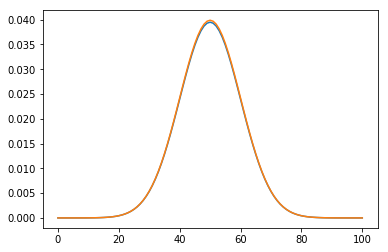

In [141]:
plt.figure()
plt.plot(fx/n_grid)
plt.plot(p_true)
plt.show()

In [147]:
(fx/n_grid - p_true).shape

(101, 101)

In [145]:
p_true.reshape(-1)

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0001, 0.0001,
       0.0001, 0.0002, 0.0002, 0.0003, 0.0004, 0.0006, 0.0008, 0.001 ,
       0.0014, 0.0018, 0.0022, 0.0028, 0.0035, 0.0044, 0.0054, 0.0066,
       0.0079, 0.0094, 0.0111, 0.013 , 0.015 , 0.0171, 0.0194, 0.0218,
       0.0242, 0.0266, 0.029 , 0.0312, 0.0333, 0.0352, 0.0368, 0.0381,
       0.0391, 0.0397, 0.0399, 0.0397, 0.0391, 0.0381, 0.0368, 0.0352,
       0.0333, 0.0312, 0.029 , 0.0266, 0.0242, 0.0218, 0.0194, 0.0171,
       0.015 , 0.013 , 0.0111, 0.0094, 0.0079, 0.0066, 0.0054, 0.0044,
       0.0035, 0.0028, 0.0022, 0.0018, 0.0014, 0.001 , 0.0008, 0.0006,
       0.0004, 0.0003, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    ])

In [111]:
## testing the slope estimation
x,p = dl.load_toy_mixture(opt=0)
v = np.ones([x.shape[0]])
c = 0
a_hat = pf.ML_slope(sample,c=c)
a_true = np.array([2,0])
l_hat = np.sum(np.log(a_hat/(np.exp(a_hat)-1))) + a_hat.dot(np.sum((x.T*v).T,axis=0))/np.sum(v) - c*np.sum(a_hat**2)
print(l_hat)
l_true = np.sum(np.log(a_true[a_true!=0]/(np.exp(a_true[a_true!=0])-1))) +\
            a_true.dot(np.sum((x.T*v).T,axis=0))/np.sum(v) - c*np.sum(a_true**2)
print(l_true)


slope parameter a =  [2. 0.]
0.15459550129291477
0.1547066384287934


In [104]:
np.log(np.sum(a_hat/(np.exp(a_hat)-1)))

0.33106698252447075

In [105]:
np.log(np.sum(a_true[a_true!=0]/(np.exp(a_true[a_true!=0])-1)))

-1.1614393615711958

In [108]:
a_hat

array([1.8231, 0.0129])

In [109]:
a_true

array([2, 0])

In [3]:
## testing f_slope
a = np.array([2,0])
x = sample[0:3,:]
pf.f_slope(x,a)

array([1.971 , 0.8856, 1.0603])

In [4]:
np.array([[0.1],[0.5]]).shape

(2, 1)

In [125]:
## testing the bump estimation
x = dl.load_toy_mixture(opt=1)
pf.ML_bump(x)

# mu=(0.50,0.20)
# sigma=(0.10,0.10)


(array([0.4985, 0.2059]), array([0.0998, 0.0934]))

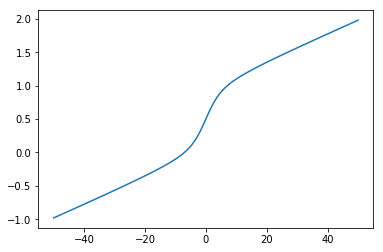

In [96]:
a = np.linspace(-50,50,100)
f = np.exp(a)/(np.exp(a)-1) - 1/a +2*0.01*a
plt.figure()
plt.plot(a,f)
plt.show()

# Unit test for mixture_fit

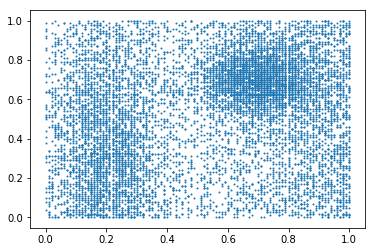

In [204]:
x,param = dl.load_x_mixture(opt=2)
plt.figure()
plt.scatter(x[:,0],x[:,1],s=1)
plt.show()

In [219]:
pf.mixture_fit(x,2,n_itr=200,verbose=True)

## initialization
# iteration i=0
# w=[0.5  0.25 0.25]
# mu=[[0.737  0.6011]
 [0.2135 0.4263]]
# sigma=[[0.1421 0.2421]
 [0.1071 0.2709]]
# weight diff=1.0

# iteration i=1
# w=[0.4848 0.2946 0.2206]
# mu=[[0.732  0.6436]
 [0.207  0.3785]]
# sigma=[[0.1244 0.1979]
 [0.097  1.    ]]
# weight diff=0.0891225443513301

# iteration i=2
# w=[0.4635 0.3111 0.2253]
# mu=[[0.7242 0.6669]
 [0.2035 0.3824]]
# sigma=[[0.1166 0.1646]
 [0.0952 1.    ]]
# weight diff=0.04258132989077018

# iteration i=3
# w=[0.4484 0.3218 0.2298]
# mu=[[0.7194 0.6843]
 [0.2016 0.3939]]
# sigma=[[0.113  0.1406]
 [0.0947 1.    ]]
# weight diff=0.030215526488416633

# iteration i=4
# w=[0.4395 0.3266 0.2339]
# mu=[[0.7163 0.6939]
 [0.2006 0.4024]]
# sigma=[[0.1116 0.1259]
 [0.0949 1.    ]]
# weight diff=0.017922339294046602

# iteration i=5
# w=[0.4351 0.327  0.238 ]
# mu=[[0.7144 0.6995]
 [0.2    0.4076]]
# sigma=[[0.1111 0.1178]
 [0.0954 1.    ]]
# weight diff=0.008788535856979751

## mixture_fit: learned parameters


(array([0.4331, 0.3252, 0.2417]),
 array([ 1.0124, -0.3883]),
 array([[0.713 , 0.7025],
        [0.1984, 0.41  ]]),
 array([[0.1109, 0.1131],
        [0.0907, 1.    ]]))

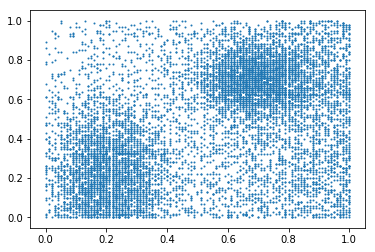

# w=[0.4059 0.3286 0.2655]
# a=[ 1.2466 -0.4568]
# mu=[[0.7067 0.6995]
 [0.2014 0.2168]]
# sigma=[[0.1123 0.1169]
 [0.0957 0.176 ]]
# weight diff=0.006145083417570474

# l_true=0.3149116979537055
# l_hat=0.30755407858421885


In [245]:
x,param = dl.load_x_mixture(opt=2)
plt.figure()
plt.scatter(x[:,0],x[:,1],s=1)
plt.show()

a,mu,sigma,w = param

def get_l(x,a,mu,sigma,w):
    fx = pf.f_all(x,a,mu,sigma,w)
    return np.mean(np.log(fx))
l_true = get_l(x,a,mu,sigma,w)
a_hat,mu_hat,sigma_hat,w_hat = pf.mixture_fit(x,2,verbose=False,random_state=2)
l_hat = get_l(x,a_hat,mu_hat,sigma_hat,w_hat)

print('# l_true=%s'%l_true)
print('# l_hat=%s'%l_hat)


In [241]:
a_hat

array([ 1.2466, -0.4568])

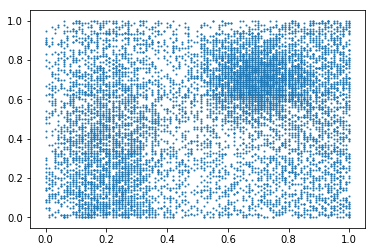

In [245]:
x,x_p,p = load_toy_mixture(opt=3)
plt.figure()
plt.scatter(x[:,0],x[:,1],s=1)
plt.show()

In [220]:
w = np.array([0.4,0.3,0.3],dtype=float)
a = np.array([2,0],dtype=float)
mu = np.array([[0.2,0.2],[0.7,0.7]],dtype=float)
sigma = np.array([[0.1,0.5],[0.1,0.1]],dtype=float)
def get_l(x,a,mu,sigma,w):
    fx = f_all(x,a,mu,sigma,w)
    return np.sum(np.log(fx))
l_true = get_l()

## initialization
Slope: w=0.5, a=0.2541162109375
Bump 0: w=0.16666666666666666, mu=[0.76128966], sigma=[0.11691044]
Bump 1: w=0.16666666666666666, mu=[0.17178368], sigma=[0.10836314]
Bump 2: w=0.16666666666666666, mu=[0.51982992], sigma=[0.12873405]


Slope: w=1.0, a=0.2541162109375
Bump 0: w=0.0, mu=[0.74339921], sigma=[0.00024518]
Bump 1: w=0.0, mu=[0.17862502], sigma=[0.00025006]
Bump 2: w=0.0, mu=[0.54311873], sigma=[0.00057089]




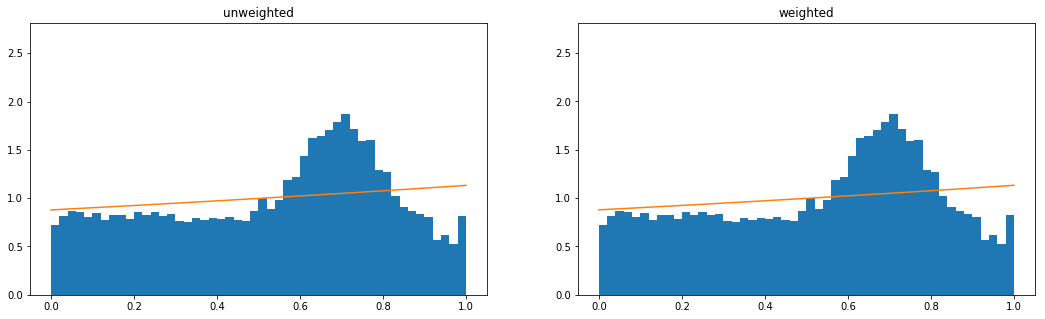

(array([1., 0., 0., 0.]), 0.2541162109375, array([[0.74339921],
        [0.17862502],
        [0.54311873]]), array([[0.00024518],
        [0.00025006],
        [0.00057089]]))

In [268]:
pf.mixture_fit(x,3,verbose=True)

In [255]:
x = np.load('./debug/x.npy')
w = np.load('./debug/w.npy')

In [269]:
pf.ML_bump(x,w)

(0.6374975697127904, 0.0005366703109592807)

In [261]:
np.sum(np.isnan(w))

0

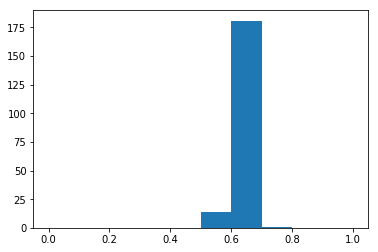

In [266]:
plt.figure()
plt.hist(x,weights=w)
plt.show()